# Compare your Network with State-Of-the-Art Networks

### Import Libraries

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights, vgg19, VGG19_Weights
from torch.utils.data import random_split, ConcatDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torcheval.metrics.functional import (multiclass_accuracy, 
                                          multiclass_confusion_matrix, 
                                          multiclass_precision, 
                                          multiclass_recall)
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

### Load the Data

In [47]:
# Batch size for training, validation and testing datasets
batch_size = 32

# Percentages for training, validation and training sets
train_split = 0.6
valid_split = 0.2
test_split = 0.2

In [48]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ])

In [49]:
train_data = datasets.CIFAR10('./data', train=True, transform=transform, download=True)
test_data = datasets.CIFAR10('./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
# Concatenate the datasets
full_dataset = ConcatDataset([train_data, test_data])

len_full_dataset = len(full_dataset)
print("Full dataset length", len_full_dataset)

Full dataset length 60000


In [51]:
# Split data into training, validation and test datasets

# Seed the generator to achieve the same splits everytime
split_generator = torch.Generator().manual_seed(42)

train_size = int(np.floor(train_split * len_full_dataset))
valid_size = int(np.floor(valid_split * len_full_dataset))
test_size = int(np.floor(test_split * len_full_dataset))

train_dataset, valid_dataset, test_dataset = random_split(full_dataset, 
                                                               [train_size, valid_size, test_size], 
                                                               split_generator)

In [52]:
print("Train dataset length: ", len(train_dataset))
print("Validation dataset length: ", len(valid_dataset))
print("Test dataset length: ", len(test_dataset))

Train dataset length:  36000
Validation dataset length:  12000
Test dataset length:  12000


In [53]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)

In [54]:
# Image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

---
### ResNet50 Model

In [55]:
# Load the pretrained model
resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)

In [56]:
# Print the model structure
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
print(resnet50.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [58]:
# Freeze parameters
# for param in resnet50.parameters():
#     param.requires_grad = False

### ResNet50 Custom Classifier

In [59]:
n_inputs = resnet50.fc.in_features

fc = nn.Sequential(nn.Linear(n_inputs, 1024),
                   nn.ReLU(),
#                    nn.Dropout(0.5),
                   nn.Linear(1024, 512),
                   nn.ReLU(),
#                    nn.Dropout(0.5),
                   nn.Linear(512, 10))

resnet50.fc = fc

In [60]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU ...')
else:
    print('Training on GPU ...')

Training on GPU ...


In [61]:
if train_on_gpu:
    resnet50.cuda()

In [62]:
print(resnet50.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=10, bias=True)
)


### Loss Function & Optimizer

In [63]:
criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

### Train the Network

In [64]:
n_epochs = 10

valid_loss_min = np.Inf

train_losses, valid_losses = [], []

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    ############# Train the model #############
    resnet50.train()
    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        
        output = resnet50(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
    ############# Train the model #############
    with torch.no_grad():
        resnet50.eval()
        for images, labels in valid_loader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
                
            output = resnet50(images)
            loss = criterion(output, labels)
            valid_loss += loss.item() * images.size(0)
            
    # Calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Save model when validation loss decreases
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min,valid_loss))
        
        torch.save(resnet50.state_dict(), 'model_resnet50.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.911291 	Validation Loss: 0.680891
Validation loss decreased (inf --> 0.680891). Saving model ...
Epoch: 2 	Training Loss: 0.526497 	Validation Loss: 0.476980
Validation loss decreased (0.680891 --> 0.476980). Saving model ...
Epoch: 3 	Training Loss: 0.397616 	Validation Loss: 0.427434
Validation loss decreased (0.476980 --> 0.427434). Saving model ...
Epoch: 4 	Training Loss: 0.309195 	Validation Loss: 0.381226
Validation loss decreased (0.427434 --> 0.381226). Saving model ...
Epoch: 5 	Training Loss: 0.246107 	Validation Loss: 0.411232
Epoch: 6 	Training Loss: 0.196666 	Validation Loss: 0.348200
Validation loss decreased (0.381226 --> 0.348200). Saving model ...
Epoch: 7 	Training Loss: 0.159544 	Validation Loss: 0.373308
Epoch: 8 	Training Loss: 0.138508 	Validation Loss: 0.374540
Epoch: 9 	Training Loss: 0.104217 	Validation Loss: 0.366921
Epoch: 10 	Training Loss: 0.096303 	Validation Loss: 0.391237


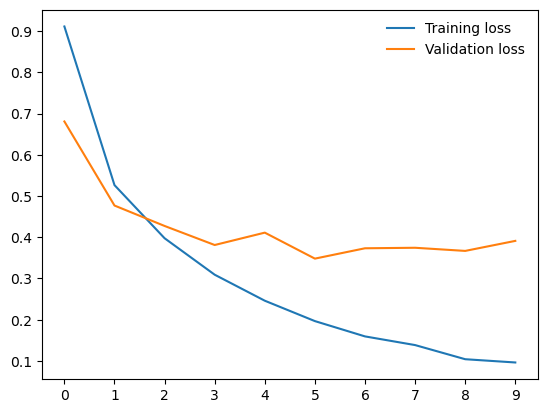

In [65]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xticks(range(10))
plt.show()

### Load the Model with Lowest Validation Loss

In [66]:
resnet50.load_state_dict(torch.load('model_resnet50.pt'))

<All keys matched successfully>

### Test the Trained Network

In [67]:
y_pred = torch.empty((0,10))
y_true = torch.empty((0,1))

test_loss = 0.0

with torch.no_grad():
    resnet50.eval()
    
    for images, labels in test_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        output = resnet50(images)
        loss = criterion(output, labels)
        test_loss += loss.item() * images.size(0)

        y_pred = torch.vstack([y_pred, output.cpu()])
        y_true = torch.vstack([y_true, labels.view(-1,1).cpu()])
        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.362343



In [68]:
_, pred = torch.max(y_pred, 1)

for i in range(10):
    class_accuracies = multiclass_accuracy(pred, torch.squeeze(y_true).to(torch.int64), average=None, num_classes=10)
    
    print('Test Accuracy of %10s: %.2f%%' % (classes[i], 100 * class_accuracies[i].item()))

overall_accuracy = multiclass_accuracy(pred, torch.squeeze(y_true).to(torch.int64))    
print('\nTest Accuracy (Overall): %.2f%% ' % (100. * overall_accuracy.item()))

Test Accuracy of   airplane: 87.02%
Test Accuracy of automobile: 96.56%
Test Accuracy of       bird: 86.27%
Test Accuracy of        cat: 71.43%
Test Accuracy of       deer: 88.09%
Test Accuracy of        dog: 90.29%
Test Accuracy of       frog: 91.93%
Test Accuracy of      horse: 91.62%
Test Accuracy of       ship: 95.60%
Test Accuracy of      truck: 86.45%

Test Accuracy (Overall): 88.55% 


---

### VGG19 Model

In [70]:
# Load the pretrained model
vgg19 = vgg19(weights=VGG19_Weights.DEFAULT)

In [71]:
# Print the model structure
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### VGG19 Custom Classifier

In [72]:
# Freeze training for all "features" layers
for param in vgg19.features.parameters():
    param.requires_grad = False

In [73]:
n_inputs = vgg19.classifier[0].in_features

fc = nn.Sequential(nn.Linear(n_inputs, 1024),
                   nn.ReLU(inplace=True),
                   nn.Dropout(p=0.5),
                   nn.Linear(1024, 512),
                   nn.ReLU(inplace=True),
                   nn.Dropout(p=0.5),
                   nn.Linear(512, 10))

vgg19.classifier = fc

In [74]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU ...')
else:
    print('Training on GPU ...')

Training on GPU ...


In [75]:
if train_on_gpu:
    vgg19.cuda()

In [76]:
print(vgg19.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=10, bias=True)
)


### Loss Function & Optimizer

In [77]:
criterion_2 = nn.CrossEntropyLoss()

optimizer_2 = optim.Adam(vgg19.parameters(), lr=0.001)

### Train the Network

In [78]:
n_epochs_2 = 10

valid_loss_min_2 = np.Inf

train_losses_2, valid_losses_2 = [], []

for epoch in range(1, n_epochs_2+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    ############# Train the model #############
    vgg19.train()
    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        optimizer_2.zero_grad()
        
        output = vgg19(images)
        loss = criterion_2(output, labels)
        loss.backward()
        optimizer_2.step()
        
        train_loss += loss.item() * images.size(0)
        
    ############# Train the model #############
    with torch.no_grad():
        vgg19.eval()
        for images, labels in valid_loader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
                
            output = vgg19(images)
            loss = criterion_2(output, labels)
            valid_loss += loss.item() * images.size(0)
            
    # Calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    train_losses_2.append(train_loss)
    valid_losses_2.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Save model when validation loss decreases
    if valid_loss <= valid_loss_min_2:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min_2,valid_loss))
        
        torch.save(vgg19.state_dict(), 'model_vgg19.pt')
        valid_loss_min_2 = valid_loss

Epoch: 1 	Training Loss: 0.758496 	Validation Loss: 0.475831
Validation loss decreased (inf --> 0.475831). Saving model ...
Epoch: 2 	Training Loss: 0.525372 	Validation Loss: 0.476123
Epoch: 3 	Training Loss: 0.440998 	Validation Loss: 0.441998
Validation loss decreased (0.475831 --> 0.441998). Saving model ...
Epoch: 4 	Training Loss: 0.385494 	Validation Loss: 0.460373
Epoch: 5 	Training Loss: 0.349347 	Validation Loss: 0.463658
Epoch: 6 	Training Loss: 0.333999 	Validation Loss: 0.485902
Epoch: 7 	Training Loss: 0.316971 	Validation Loss: 0.484615
Epoch: 8 	Training Loss: 0.288857 	Validation Loss: 0.484028
Epoch: 9 	Training Loss: 0.278182 	Validation Loss: 0.519969
Epoch: 10 	Training Loss: 0.263001 	Validation Loss: 0.522400


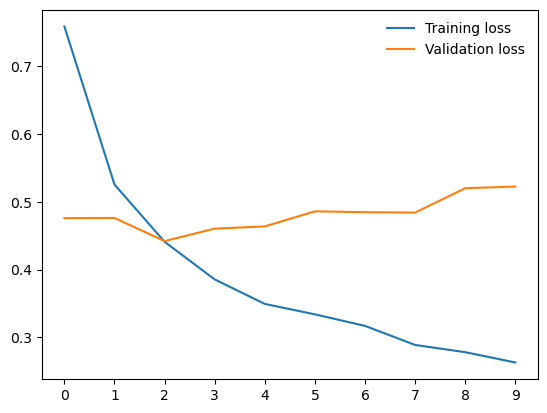

In [80]:
plt.plot(train_losses_2, label='Training loss')
plt.plot(valid_losses_2, label='Validation loss')
plt.legend(frameon=False)
plt.xticks(range(10))
plt.show()

### Load the Model with Lowest Validation Loss

In [81]:
vgg19.load_state_dict(torch.load('model_vgg19.pt'))

<All keys matched successfully>

### Test the Trained Network

In [82]:
y_pred = torch.empty((0,10))
y_true = torch.empty((0,1))

test_loss = 0.0

with torch.no_grad():
    vgg19.eval()
    
    for images, labels in test_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        output = vgg19(images)
        loss = criterion_2(output, labels)
        test_loss += loss.item() * images.size(0)

        y_pred = torch.vstack([y_pred, output.cpu()])
        y_true = torch.vstack([y_true, labels.view(-1,1).cpu()])
        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.458340



In [83]:
_, pred = torch.max(y_pred, 1)

for i in range(10):
    class_accuracies = multiclass_accuracy(pred, torch.squeeze(y_true).to(torch.int64), average=None, num_classes=10)
    
    print('Test Accuracy of %10s: %.2f%%' % (classes[i], 100 * class_accuracies[i].item()))

overall_accuracy = multiclass_accuracy(pred, torch.squeeze(y_true).to(torch.int64))    
print('\nTest Accuracy (Overall): %.2f%% ' % (100. * overall_accuracy.item()))

Test Accuracy of   airplane: 77.25%
Test Accuracy of automobile: 95.35%
Test Accuracy of       bird: 77.17%
Test Accuracy of        cat: 74.32%
Test Accuracy of       deer: 85.05%
Test Accuracy of        dog: 76.51%
Test Accuracy of       frog: 91.93%
Test Accuracy of      horse: 87.59%
Test Accuracy of       ship: 94.77%
Test Accuracy of      truck: 91.10%

Test Accuracy (Overall): 85.13% 
